In [1]:
%matplotlib inline
import numpy as np
import soundfile
import matplotlib.pyplot as plt
from scipy.fftpack import fft

In [2]:
filename = '../../../../../datasets/fender/train/m_67.wav'
N = 32000
y, fs = soundfile.read(filename, frames=N)
x = np.linspace(0, (N-1.)/fs, N)

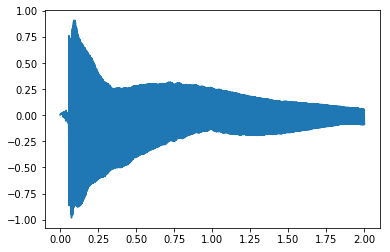

In [3]:
plt.figure()
plt.plot(x, y)

In [4]:
Y = fft(y)
S = 2./N * np.abs(Y[:N/2])
F = np.linspace(0, 0.5*fs, N/2)

S /= S.sum() 

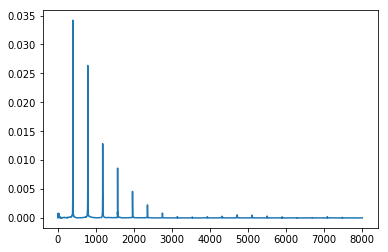

In [5]:
plt.figure()
plt.plot(F, S)

In [6]:
N = 10000
samples = np.random.choice(F, size=N, p=S)
samples = samples.reshape(-1, 1)

(array([  2.89000000e+02,   7.10000000e+01,   8.50000000e+01,
          1.54000000e+02,   1.94400000e+03,   4.55000000e+02,
          3.50000000e+01,   6.20000000e+01,   1.48000000e+02,
          1.75200000e+03,   4.27000000e+02,   1.32000000e+02,
          5.60000000e+01,   6.30000000e+01,   1.29500000e+03,
          2.16000000e+02,   1.23000000e+02,   9.30000000e+01,
          6.90000000e+01,   4.05000000e+02,   1.50000000e+02,
          2.90000000e+01,   3.60000000e+01,   4.80000000e+01,
          4.93000000e+02,   6.20000000e+01,   3.00000000e+01,
          2.70000000e+01,   3.00000000e+01,   2.36000000e+02,
          4.90000000e+01,   8.00000000e+00,   8.00000000e+00,
          1.00000000e+01,   1.35000000e+02,   1.30000000e+01,
          6.00000000e+00,   1.00000000e+00,   8.00000000e+00,
          2.50000000e+01,   4.00000000e+00,   3.00000000e+00,
          2.00000000e+00,   4.00000000e+00,   1.40000000e+01,
          4.00000000e+00,   2.00000000e+00,   2.00000000e+00,
        

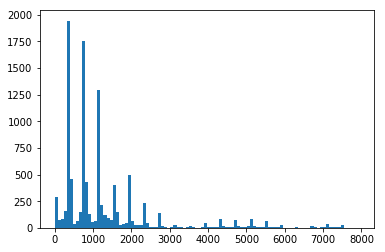

In [7]:
plt.figure()
plt.hist(samples, 100)

In [8]:
print samples.shape
X2 = np.hstack(( samples/np.max(np.abs(samples)), samples/np.max(np.abs(samples)) ))
print type(X2)
oeoe = X2.copy()

(10000, 1)
<type 'numpy.ndarray'>


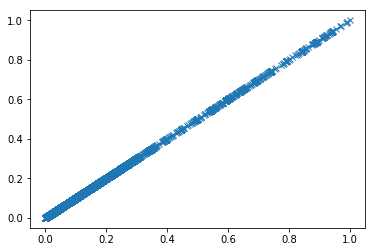

In [9]:
plt.plot(X2[:,0], X2[:,1], 'x')

Automatically created module for IPython interactive environment


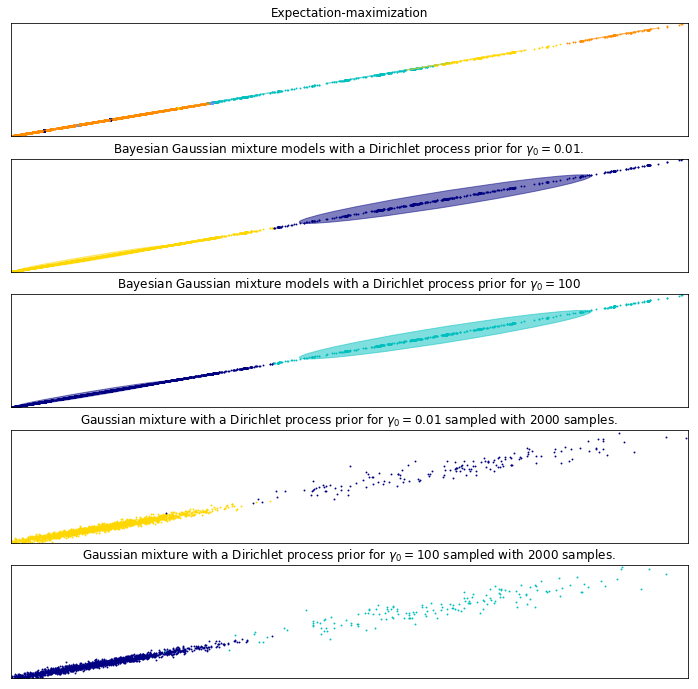

In [10]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

print(__doc__)

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y, means, covariances, index, title):
    splot = plt.subplot(5, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(0., 1.)
    plt.ylim(0., 1.)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())


def plot_samples(X, Y, n_components, index, title):
    plt.subplot(5, 1, 4 + index)
    for i, color in zip(range(n_components), color_iter):
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], .8, color=color)

    plt.xlim(0., 1.)
    plt.ylim(0., 1.)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())


# Parameters
n_samples = N

# Generate random sample following a sine curve
np.random.seed(0)
X = np.zeros((n_samples, 2))
step = 4. * np.pi / n_samples

for i in range(X.shape[0]):
    x = i * step - 6.
    X[i, 0] = x + np.random.normal(0, 0.1)
    X[i, 1] = 3. * (np.sin(x) + np.random.normal(0, .2))

X = X2.copy()
plt.figure(figsize=(10, 10))
plt.subplots_adjust(bottom=.04, top=0.95, hspace=.2, wspace=.05,
                    left=.03, right=.97)

# Fit a Gaussian mixture with EM using ten components
gmm = mixture.GaussianMixture(n_components=10, covariance_type='full',
                              max_iter=100).fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'Expectation-maximization')

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10, covariance_type='full', weight_concentration_prior=1e-2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(2),
    init_params="random", max_iter=100, random_state=2).fit(X)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
             "Bayesian Gaussian mixture models with a Dirichlet process prior "
             r"for $\gamma_0=0.01$.")

X_s, y_s = dpgmm.sample(n_samples=2000)
plot_samples(X_s, y_s, dpgmm.n_components, 0,
             "Gaussian mixture with a Dirichlet process prior "
             r"for $\gamma_0=0.01$ sampled with $2000$ samples.")

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10, covariance_type='full', weight_concentration_prior=1e+2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(2),
    init_params="kmeans", max_iter=100, random_state=2).fit(X)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 2,
             "Bayesian Gaussian mixture models with a Dirichlet process prior "
             r"for $\gamma_0=100$")

X_s, y_s = dpgmm.sample(n_samples=2000)
plot_samples(X_s, y_s, dpgmm.n_components, 1,
             "Gaussian mixture with a Dirichlet process prior "
             r"for $\gamma_0=100$ sampled with $2000$ samples.")

plt.show()

In [11]:
X.shape

(10000, 2)